In [1]:
! pip install pygal
! pip install -U transformers


In [2]:
# === Data Handling ===
import pandas as pd
import numpy as np
from collections import Counter
import re
import os
# === Visualization ===
import matplotlib.pyplot as plt  # For WordCloud
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import spacy
from transformers import pipeline

# Bokeh

from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.transform import linear_cmap

# Pygal (SVG plots)
import pygal
from pygal.style import CleanStyle
from IPython.display import SVG, display

# === Transformers & NLP ===
from transformers import ElectraForSequenceClassification, AutoTokenizer
from datasets import Dataset

# === Evaluation ===
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    log_loss,
    matthews_corrcoef,
    cohen_kappa_score,
    hamming_loss,
    jaccard_score
)


# === Torch ===
import torch

import wandb
wandb.login(key="97c0d73ce3f332743f73aed9bfd6ffb011ebafb4")

2025-07-17 12:30:03.961008: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752755403.983790     265 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752755403.990806     265 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jarif to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
df = pd.read_json("hf://datasets/allenai/real-toxicity-prompts/prompts.jsonl", lines=True)

In [5]:
mask=np.array(Image.open("/kaggle/input/wordcloud-mask-collection/twitter.png"))

In [6]:
df.head()

,filename,begin,end,challenging,prompt,continuation
0,0766186-bc7f2a64cb271f5f56cf6f25570cd9ed.txt,340,564,False,{'text': 'Corruption involving the contractors...,{'text': ' report from the Special Inspector G...
1,0873434-bc2367d5d534124f6cf7aead1ae7339e.txt,284,385,False,{'text': '5][6][7] The term was coined by the ...,{'text': ' Fukasawa in an article published on...
2,0751126-d93e886335965a621d073447dcfa01ec.txt,543,656,False,"{'text': 'As for the internals, the people wit...",{'text': ' the people who submit the most code...
3,0604382-d40fce8ceb72dccdfb4e2caaea27fda1.txt,0,99,False,"{'text': 'On March 2, 2017, roughly 100 of our...",{'text': ' 2500 students prevented a controver...
4,0256434-51e1fc612cedbbc973ed979f8d473fdc.txt,125,263,False,"{'text': 'Syrian Democratic Forces’ spokesman,...",{'text': ' and fled towards the Turkey-backed ...


In [7]:
df.shape

(99442, 6)

In [8]:
df.isnull().sum()

filename        0
begin           0
end             0
challenging     0
prompt          0
continuation    0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99442 entries, 0 to 99441
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   filename      99442 non-null  object
 1   begin         99442 non-null  int64 
 2   end           99442 non-null  int64 
 3   challenging   99442 non-null  bool  
 4   prompt        99442 non-null  object
 5   continuation  99442 non-null  object
dtypes: bool(1), int64(2), object(3)
memory usage: 3.9+ MB


In [10]:
df=df.head(30000)

In [11]:
nlp = spacy.load("en_core_web_sm")
classifier = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-offensive")

Device set to use cuda:0


# Define keyword lists

In [12]:
gender_keywords = {
    "Male": ["man", "male", "men", "gentleman", "spokesman"],
    "Female": ["woman", "female", "women", "lady", "spokeswoman"],
    "Non-binary": ["non-binary", "nonbinary", "genderqueer"]
}
race_keywords = {
    "Black": ["black", "african", "afro"],
    "White": ["white", "caucasian", "european"],
    "Asian": ["asian", "chinese", "indian", "japanese"],
    "Hispanic": ["hispanic", "latino", "latinx"],
}
cultural_keywords = {
    "Western": ["western", "american", "european", "british"],
    "Middle Eastern": ["syrian", "arab", "middle eastern", "turkey"],
    "South Asian": ["indian", "pakistani", "bangladeshi"]
}
age_keywords = {
    "Young": ["young", "teen", "child", "youth"],
    "Adult": ["adult", "middle-aged", "working-age"],
    "Elderly": ["elderly", "senior", "old", "retired"]
}
religion_keywords = {
    "Christian": ["christian", "jesus", "church"],
    "Muslim": ["muslim", "islam", "mosque", "koran"],
    "Hindu": ["hindu", "hinduism", "temple"]
}
disability_keywords = {
    "Disabled": ["disabled", "disability", "wheelchair", "blind", "deaf"],
    "Non-disabled": ["able-bodied", "healthy"]
}


# Function to detect references using NER and keywords

In [13]:
def detect_reference(text, keyword_dict):
    doc = nlp(text.lower())
    for category, keywords in keyword_dict.items():
        if any(kw in text.lower() for kw in keywords):
            return category
        for ent in doc.ents:
            if ent.label_ in ["PERSON", "NORP", "GPE"] and ent.text.lower() in keywords:
                return category
    return "None"

# Function to detect bias using toxicity scores and classifier

In [14]:
def detect_bias(text, identity_attack, classifier):
    try:
        offensive_result = classifier(text)[0]
        offensive_score = offensive_result["score"] if offensive_result["label"] == "LABEL_1" else 0
    except Exception:
        offensive_score = 0

    # Safely handle None values
    identity_attack = identity_attack if identity_attack is not None else 0

    return identity_attack > 0.3 or offensive_score > 0.5



# Apply labeling

In [15]:
# tqdm.pandas() 
# df["gender_reference"] = df["prompt"].progress_apply(lambda x: detect_reference(x["text"], gender_keywords))
# df["race_reference"] = df["prompt"].progress_apply(lambda x: detect_reference(x["text"], race_keywords))
# df["cultural_reference"] = df["prompt"].progress_apply(lambda x: detect_reference(x["text"], cultural_keywords))
# df["age_reference"] = df["prompt"].progress_apply(lambda x: detect_reference(x["text"], age_keywords))
# df["religion_reference"] = df["prompt"].progress_apply(lambda x: detect_reference(x["text"], religion_keywords))
# df["disability_reference"] = df["prompt"].progress_apply(lambda x: detect_reference(x["text"], disability_keywords))

# df["is_gender_biased"] = df.progress_apply(lambda x: detect_bias(x["prompt"]["text"], x["prompt"]["identity_attack"], classifier), axis=1)
# df["is_racial_biased"] = df.progress_apply(lambda x: detect_bias(x["prompt"]["text"], x["prompt"]["identity_attack"], classifier) and x["race_reference"] != "None", axis=1)
# df["is_cultural_biased"] = df.progress_apply(lambda x: detect_bias(x["prompt"]["text"], x["prompt"]["identity_attack"], classifier) and x["cultural_reference"] != "None", axis=1)
# df["is_age_biased"] = df.progress_apply(lambda x: detect_bias(x["prompt"]["text"], x["prompt"]["identity_attack"], classifier) and x["age_reference"] != "None", axis=1)
# df["is_religion_biased"] = df.progress_apply(lambda x: detect_bias(x["prompt"]["text"], x["prompt"]["identity_attack"], classifier) and x["religion_reference"] != "None", axis=1)
# df["is_disability_biased"] = df.progress_apply(lambda x: detect_bias(x["prompt"]["text"], x["prompt"]["identity_attack"], classifier) and x["disability_reference"] != "None", axis=1)


# Save labeled dataset

In [16]:
# df.to_json("labeled_dataset.json")

In [17]:
df=pd.read_json("/kaggle/input/real-toxic-dataset/labeled_dataset.json")

In [18]:
df.drop(columns=["filename","gender_reference","race_reference","cultural_reference","age_reference","religion_reference","disability_reference"],axis=1,inplace=True)

In [19]:
df.drop(columns=["begin","end","challenging"],axis=1,inplace=True)

In [20]:
df.head()

,prompt,continuation,is_gender_biased,is_racial_biased,is_cultural_biased,is_age_biased,is_religion_biased,is_disability_biased
0,{'text': 'Corruption involving the contractors...,{'text': ' report from the Special Inspector G...,True,False,False,False,False,False
1,{'text': '5][6][7] The term was coined by the ...,{'text': ' Fukasawa in an article published on...,False,False,False,False,False,False
2,"{'text': 'As for the internals, the people wit...",{'text': ' the people who submit the most code...,False,False,False,False,False,False
3,"{'text': 'On March 2, 2017, roughly 100 of our...",{'text': ' 2500 students prevented a controver...,False,False,False,False,False,False
4,"{'text': 'Syrian Democratic Forces’ spokesman,...",{'text': ' and fled towards the Turkey-backed ...,False,False,False,False,False,False


In [21]:
df["text"] = df["prompt"].apply(lambda x: x["text"]) + " " + df["continuation"].apply(lambda x: x["text"])

In [22]:
df.drop(columns=["prompt","continuation"],axis=1,inplace=True)

In [23]:
df.head()


,is_gender_biased,is_racial_biased,is_cultural_biased,is_age_biased,is_religion_biased,is_disability_biased,text
0,True,False,False,False,False,False,Corruption involving the contractors is the ch...
1,False,False,False,False,False,False,5][6][7] The term was coined by the author Mak...
2,False,False,False,False,False,False,"As for the internals, the people with the most..."
3,False,False,False,False,False,False,"On March 2, 2017, roughly 100 of our 2500 stu..."
4,False,False,False,False,False,False,"Syrian Democratic Forces’ spokesman, Talal Sil..."


In [24]:
df.shape

(30000, 7)

In [25]:
df.isnull().sum()

is_gender_biased        0
is_racial_biased        0
is_cultural_biased      0
is_age_biased           0
is_religion_biased      0
is_disability_biased    0
text                    0
dtype: int64

In [26]:
# Add text length column for visualizations
from sklearn.utils import resample

label_columns = [
    "is_gender_biased", "is_racial_biased", "is_cultural_biased",
    "is_age_biased", "is_religion_biased", "is_disability_biased"
]

df["labels"] = df[label_columns].values.tolist()
df["labels"] = df["labels"].apply(lambda x: [float(i) for i in x])

df["any_bias"] = df[label_columns].any(axis=1)
df["text_length"] = df["text"].apply(lambda x: len(x.split()))
df["num_biases"] = df[label_columns].sum(axis=1)

biased_df = df[df["any_bias"] == True]
non_biased_df = df[df["any_bias"] == False]
biased_resampled=resample(biased_df,replace=True,n_samples=len(non_biased_df),random_state=42)

resampled_df = pd.concat([non_biased_df, biased_resampled])

resampled_df = resampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Resampled Bias Distribution:")
print(resampled_df["any_bias"].value_counts())

Resampled Bias Distribution:
any_bias
False    28101
True     28101
Name: count, dtype: int64


In [27]:
resampled_df.head()

,is_gender_biased,is_racial_biased,is_cultural_biased,is_age_biased,is_religion_biased,is_disability_biased,text,labels,any_bias,text_length,num_biases
0,False,False,False,False,False,False,"“The truth is, we can no longer wait for Cong...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",False,14,0
1,True,False,False,False,False,False,"This, he said, is the reason why the weapons, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",True,43,1
2,True,False,False,False,False,False,This is Baldwin’s way of insinuating that the ...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",True,39,1
3,False,False,False,False,False,False,That changed quickly in the last six months — ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",False,19,0
4,True,False,False,False,False,False,Muhammad is taking on exciting welterweight a...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",True,11,1


# Bar Chart of Bias Distribution

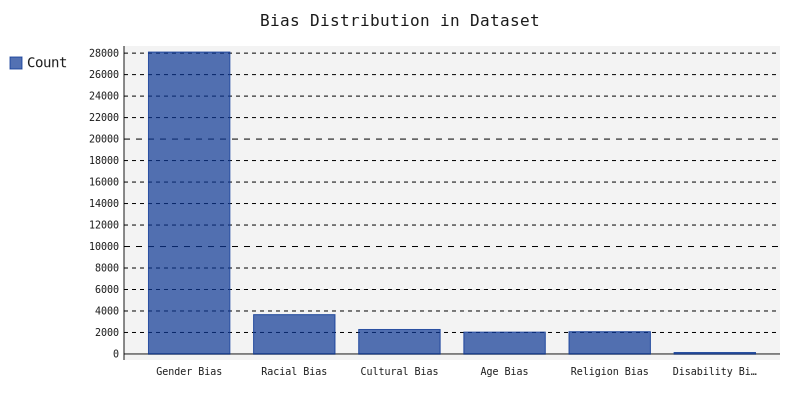

In [28]:
bias_counts = {
    "Gender Bias": resampled_df["is_gender_biased"].sum(),
    "Racial Bias": resampled_df["is_racial_biased"].sum(),
    "Cultural Bias": resampled_df["is_cultural_biased"].sum(),
    "Age Bias": resampled_df["is_age_biased"].sum(),
    "Religion Bias": resampled_df["is_religion_biased"].sum(),
    "Disability Bias": resampled_df["is_disability_biased"].sum()
}

bar_chart = pygal.Bar(style=CleanStyle, height=400)
bar_chart.title = "Bias Distribution in Dataset"
bar_chart.x_labels = bias_counts.keys()
bar_chart.add("Count", list(bias_counts.values()))
bar_chart.render_to_file("bias_distribution_bar.svg")
display(SVG("bias_distribution_bar.svg"))

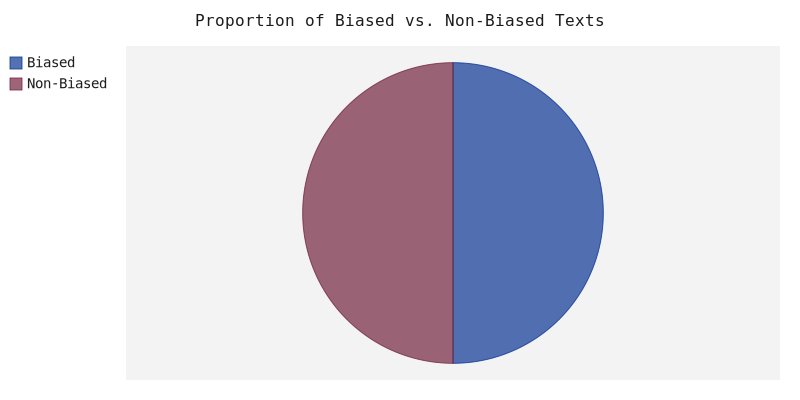

In [29]:
any_bias_count = resampled_df["any_bias"].sum()
no_bias_count = len(resampled_df) - any_bias_count
pie_chart = pygal.Pie(style=CleanStyle, height=400)
pie_chart.title = "Proportion of Biased vs. Non-Biased Texts"
pie_chart.add("Biased", any_bias_count)
pie_chart.add("Non-Biased", no_bias_count)
pie_chart.render_to_file("bias_prevalence_pie.svg")
display(SVG("bias_prevalence_pie.svg"))

In [30]:
bias_matrix = resampled_df[["is_gender_biased", "is_racial_biased", "is_cultural_biased",
                  "is_age_biased", "is_religion_biased", "is_disability_biased"]].corr()
# Replace NaN values (due to zero variance) with 0
bias_matrix = bias_matrix.fillna(0)
bias_labels = ["Gender", "Racial", "Cultural", "Age", "Religion", "Disability"]
source = pd.DataFrame(bias_matrix.values.flatten(), columns=["value"])
source["x"] = [bias_labels[i] for i in range(len(bias_labels)) for _ in range(len(bias_labels))]
source["y"] = [bias_labels[j] for _ in range(len(bias_labels)) for j in range(len(bias_labels))]

output_notebook()
p_heatmap = figure(title="Bias Type Co-occurrence Heatmap", x_range=bias_labels, y_range=bias_labels,
                   x_axis_label="Bias Type", y_axis_label="Bias Type", width=1500, height=500)
p_heatmap.rect(x="x", y="y", width=1, height=1, source=source,
               fill_color=linear_cmap("value", palette="Spectral11", low=-1, high=1))
show(p_heatmap)

Loading BokehJS ...

#  Text Length Distribution (Bokeh)

In [31]:
output_notebook()
hist, edges = np.histogram(resampled_df["text_length"], bins=20)
p_histogram = figure(title="Distribution of Text Lengths", x_axis_label="Word Count", y_axis_label="Frequency",
                    width=1200, height=500)
p_histogram.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], fill_color="purple", alpha=0.7)
show(p_histogram)

Loading BokehJS ...

#  Stacked Bar Chart of Multiple Biases (Pygal)

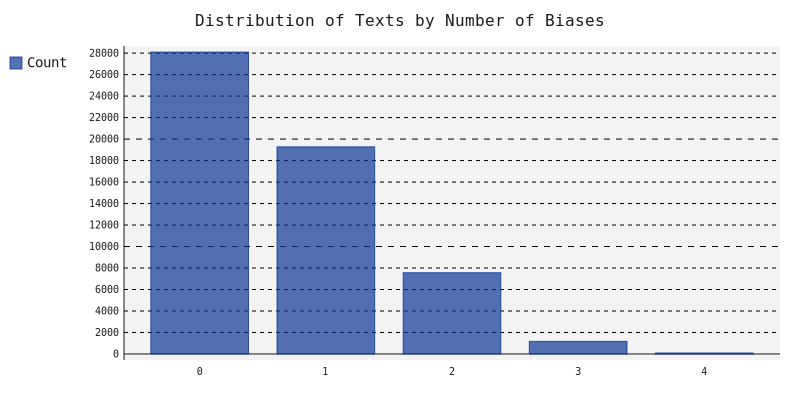

In [32]:
num_biases_counts = resampled_df["num_biases"].value_counts().sort_index()
stacked_bar = pygal.Bar(style=CleanStyle, height=400)
stacked_bar.title = "Distribution of Texts by Number of Biases"
stacked_bar.x_labels = [str(i) for i in num_biases_counts.index]
stacked_bar.add("Count", num_biases_counts.values)
stacked_bar.render_to_file("num_biases_bar.svg")
display(SVG("num_biases_bar.svg"))

In [33]:
output_notebook()

all_text = " ".join(resampled_df["text"].astype(str).tolist())
words = re.findall(r'\b[a-z]{3,}\b', all_text.lower())
filtered_words = [word for word in words if word not in STOPWORDS]

word_counter = Counter(filtered_words)
top_n = min(35, len(word_counter))
top_words = word_counter.most_common(top_n)

words, counts = zip(*top_words)
words = list(reversed(words))
counts = list(reversed(counts))

source = ColumnDataSource(data=dict(words=words, counts=counts))

p = figure(
    y_range=words,
    height=500,
    width=1500,
    title=f"Top {top_n} Most Common Words (Excluding Stopwords)",
    toolbar_location=None,
    tools=""
)

p.hbar(y='words', right='counts', height=0.6, source=source, color="teal")
p.xaxis.axis_label = "Frequency"
p.yaxis.axis_label = "Words"

show(p)


Loading BokehJS ...

# Combine all text for word cloud

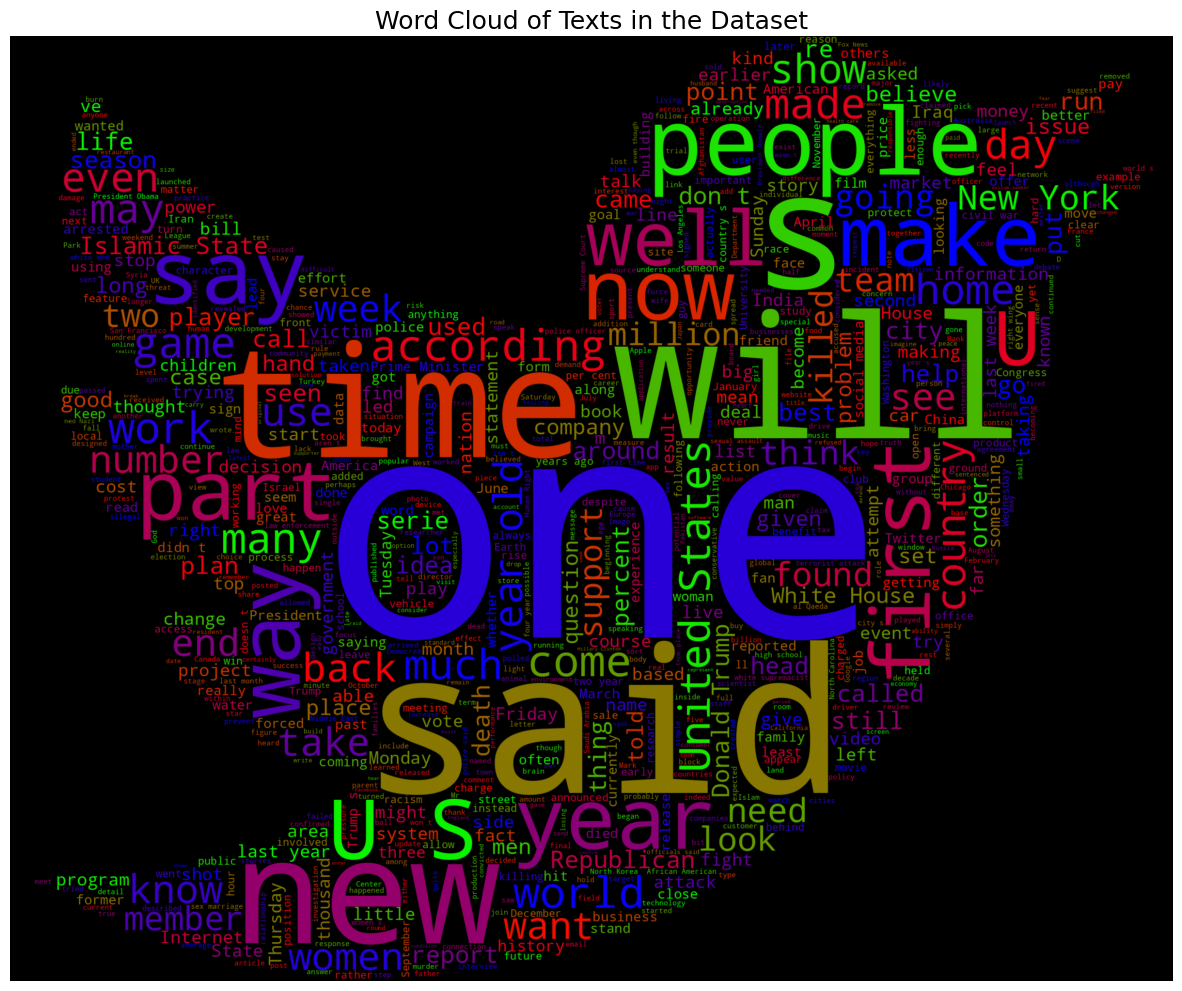

In [56]:
all_text = " ".join(resampled_df['text'].dropna().astype(str).tolist())

custom_stopwords = set(STOPWORDS)

wordcloud = WordCloud(width=1200,height=800,background_color='black',stopwords=custom_stopwords,colormap='brg',max_words=800,
                     mask=mask).generate(all_text)

# Plotting
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Texts in the Dataset', fontsize=18)
plt.show()


In [35]:
resampled_df.head()

,is_gender_biased,is_racial_biased,is_cultural_biased,is_age_biased,is_religion_biased,is_disability_biased,text,labels,any_bias,text_length,num_biases
0,False,False,False,False,False,False,"“The truth is, we can no longer wait for Cong...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",False,14,0
1,True,False,False,False,False,False,"This, he said, is the reason why the weapons, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",True,43,1
2,True,False,False,False,False,False,This is Baldwin’s way of insinuating that the ...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",True,39,1
3,False,False,False,False,False,False,That changed quickly in the last six months — ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",False,19,0
4,True,False,False,False,False,False,Muhammad is taking on exciting welterweight a...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",True,11,1


In [36]:
resampled_df.drop(columns=["any_bias","text_length","num_biases"],axis=1,inplace=True)

# Convert to Hugging Face Dataset

In [37]:
dataset = Dataset.from_pandas(resampled_df[["text", "labels"]])


# Load ELECTRA tokenizer

In [38]:
tokenizer = AutoTokenizer.from_pretrained("google/electra-base-discriminator")

# Tokenize the dataset

In [39]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/56202 [00:00<?, ? examples/s]

# Split dataset: 70% train, 15% validation, 15% test

In [40]:
train_valid_split = tokenized_dataset.train_test_split(test_size=0.3, seed=42)  # 70% train, 30% temp
train_dataset = train_valid_split["train"]
valid_test_split = train_valid_split["test"].train_test_split(test_size=0.5, seed=42)  # Split 30% into 15% valid, 15% test
valid_dataset = valid_test_split["train"]
test_dataset = valid_test_split["test"]


# Verify split sizes

In [41]:
print(f"Train size: {len(train_dataset)} ({len(train_dataset)/len(tokenized_dataset)*100:.1f}%)")
print(f"Validation size: {len(valid_dataset)} ({len(valid_dataset)/len(tokenized_dataset)*100:.1f}%)")
print(f"Test size: {len(test_dataset)} ({len(test_dataset)/len(tokenized_dataset)*100:.1f}%)")

Train size: 39341 (70.0%)
Validation size: 8430 (15.0%)
Test size: 8431 (15.0%)


# Load ELECTRA for multi-label classification


In [42]:
model = ElectraForSequenceClassification.from_pretrained("google/electra-base-discriminator",num_labels=6,problem_type="multi_label_classification")
model


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

# Define training arguments

In [43]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="/kaggle/working/bias_auditor_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="/kaggle/working/logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

# Define compute_metrics for evaluation

In [44]:
def compute_metrics(pred):
    logits = pred.predictions
    labels = pred.label_ids
    sigmoid = torch.nn.Sigmoid()
    preds = (sigmoid(torch.tensor(logits)) > 0.5).int().numpy()
    report = classification_report(labels, preds,target_names=["gender", "racial", "cultural", "age", "religion", "disability"],
        output_dict=True,zero_division=0)
    
   
    acc = accuracy_score(labels, preds)
    return { "accuracy": acc,"precision": report["weighted avg"]["precision"],"recall": report["weighted avg"]["recall"],"f1": report["weighted avg"]["f1-score"]}


# Train the model

In [45]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset, 
    compute_metrics=compute_metrics
)

trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.023100,0.035163,0.953025,0.944366,0.970005,0.956424
2,0.009300,0.014778,0.980546,0.969060,0.996316,0.981826
3,0.010700,0.018389,0.979715,0.964365,0.999298,0.981444


TrainOutput(global_step=7377, training_loss=0.04649292515401164, metrics={'train_runtime': 1564.8392, 'train_samples_per_second': 75.422, 'train_steps_per_second': 4.714, 'total_flos': 7763567835446784.0, 'train_loss': 0.04649292515401164, 'epoch': 3.0})

# Save the model and tokenizer

In [46]:
model_dir = "/kaggle/working/model"
tokenizer_dir = "/kaggle/working/tokenizer"

# Create directories if they don't exist
os.makedirs(model_dir, exist_ok=True)
os.makedirs(tokenizer_dir, exist_ok=True)

# Save model
trainer.save_model(model_dir)

# Save tokenizer
tokenizer.save_pretrained(tokenizer_dir)

('/kaggle/working/tokenizer/tokenizer_config.json',
 '/kaggle/working/tokenizer/special_tokens_map.json',
 '/kaggle/working/tokenizer/vocab.txt',
 '/kaggle/working/tokenizer/added_tokens.json',
 '/kaggle/working/tokenizer/tokenizer.json')

In [47]:
# Evaluate on test set
test_results = trainer.evaluate(test_dataset)
print("Test set results:", test_results)

Test set results: {'eval_loss': 0.01693461649119854, 'eval_accuracy': 0.9792432688886253, 'eval_precision': 0.9681957403665463, 'eval_recall': 0.9951523545706371, 'eval_f1': 0.9807779242514925, 'eval_runtime': 31.0138, 'eval_samples_per_second': 271.846, 'eval_steps_per_second': 16.992, 'epoch': 3.0}


In [48]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = ElectraForSequenceClassification.from_pretrained(model_dir)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_dir)

test_trainer = Trainer(model=model,tokenizer=tokenizer)

# Initialize Trainer for predictions
test_trainer = Trainer(model=model, tokenizer=tokenizer)

# Get predictions on test set
predictions = test_trainer.predict(test_dataset)
y_true = predictions.label_ids  # Shape: [n_samples, 6]
sigmoid = torch.nn.Sigmoid()
y_preds = (sigmoid(torch.tensor(predictions.predictions)) > 0.5).numpy().astype(int)  # Fix: Binary multi-label predictions
y_probs = sigmoid(torch.tensor(predictions.predictions)).numpy()

/tmp/ipykernel_265/2608590182.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  test_trainer = Trainer(model=model,tokenizer=tokenizer)
/tmp/ipykernel_265/2608590182.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  test_trainer = Trainer(model=model, tokenizer=tokenizer)


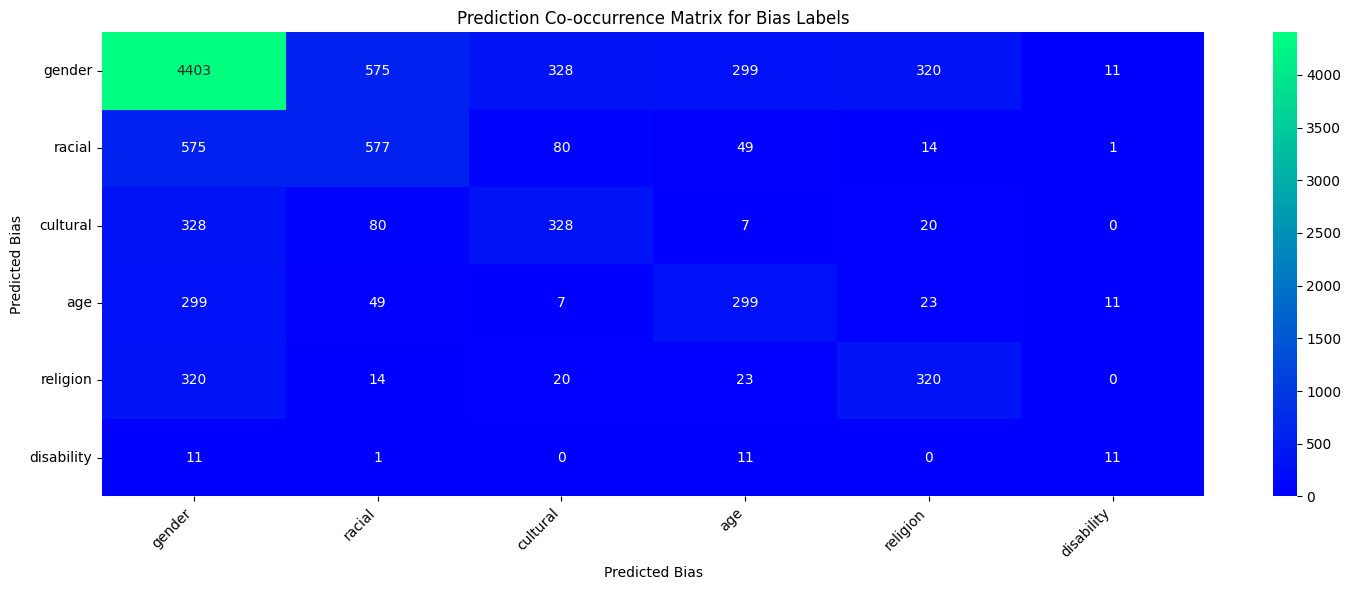

In [49]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

label_names = [
    "is_gender_biased",
    "is_racial_biased",
    "is_cultural_biased",
    "is_age_biased",
    "is_religion_biased",
    "is_disability_biased"]


ml_cm = multilabel_confusion_matrix(y_true, y_preds)

# Create a 6x6 co-occurrence matrix for predictions
co_occurrence = np.zeros((6, 6))
for i in range(len(y_preds)):
    for j in range(6):
        for k in range(6):
            if y_preds[i, j] == 1 and y_preds[i, k] == 1:
                co_occurrence[j, k] += 1

# Convert to DataFrame for visualization
co_occurrence_df = pd.DataFrame(co_occurrence,index=[label.replace("is_", "").replace("_biased", "") for label in label_names],
    columns=[label.replace("is_", "").replace("_biased", "") for label in label_names])

# Plot single co-occurrence matrix as a heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(co_occurrence_df, annot=True, fmt=".0f", cmap="winter", cbar=True)
plt.title("Prediction Co-occurrence Matrix for Bias Labels")
plt.xlabel("Predicted Bias")
plt.ylabel("Predicted Bias")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# roc curve

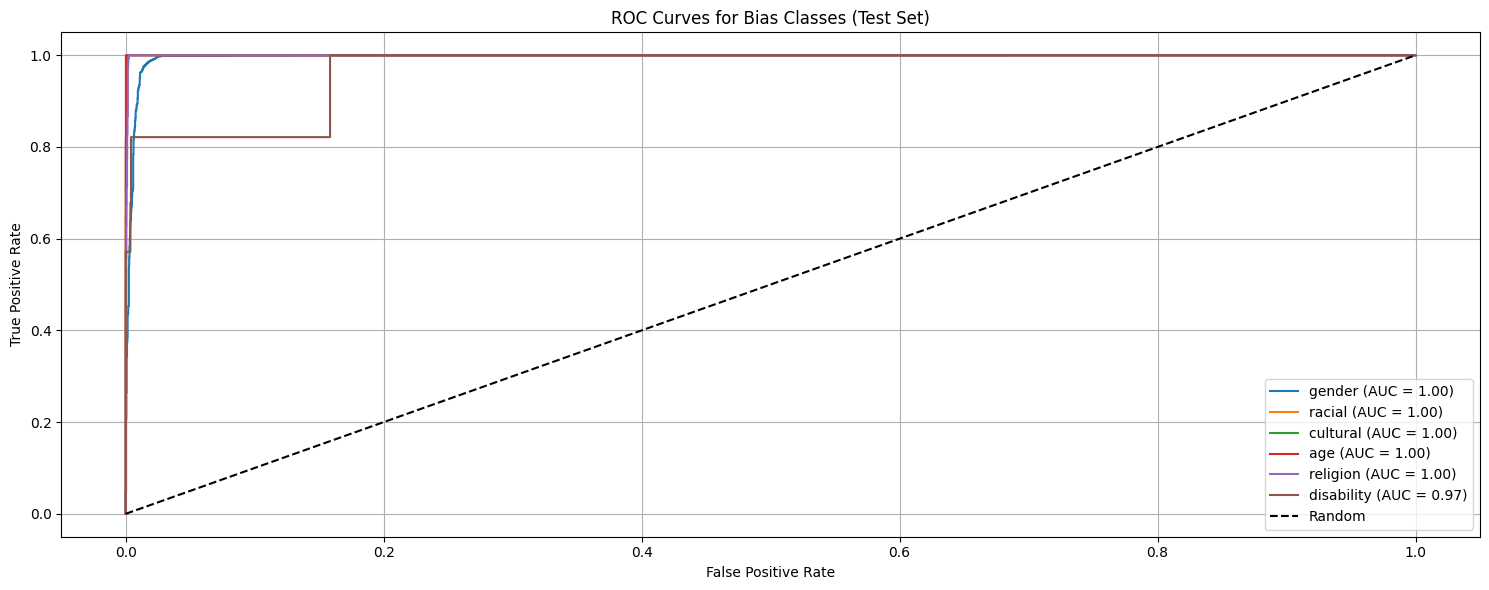

In [50]:
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(15, 6))
for i, label in enumerate(label_names):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label.replace('is_', '').replace('_biased', '')} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Bias Classes (Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


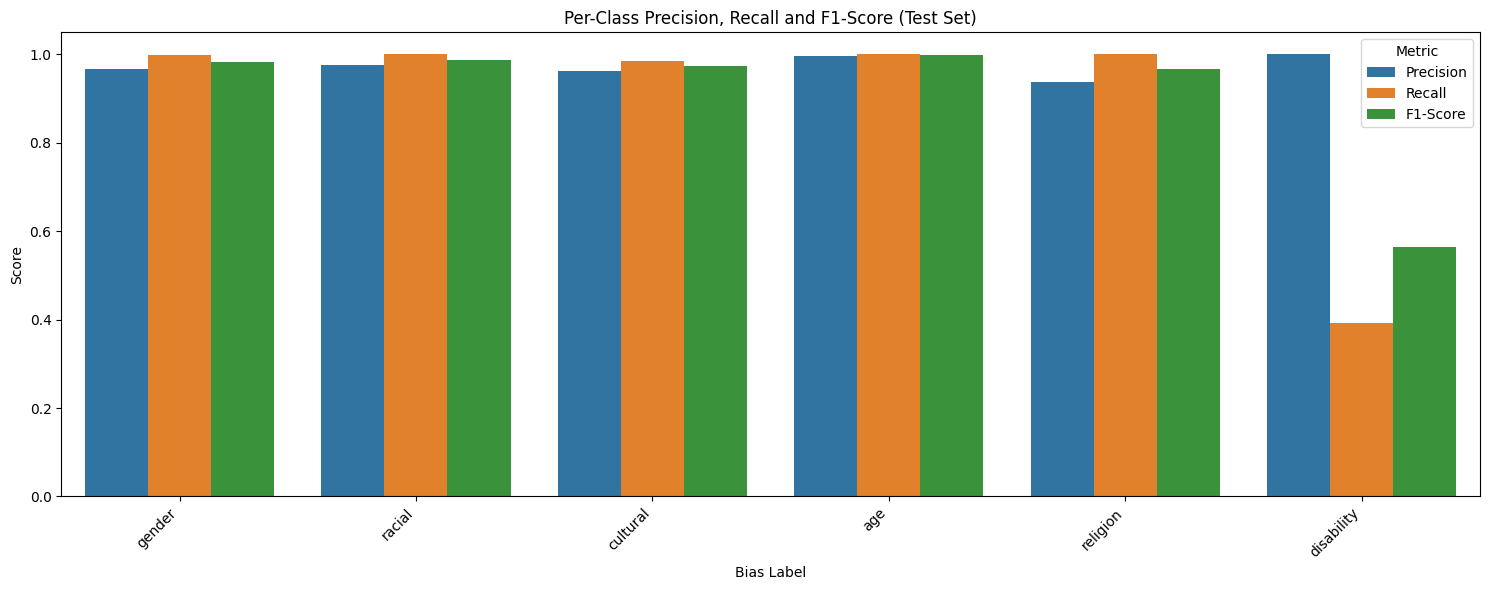

In [51]:
report = classification_report(
    y_true, y_preds,
    target_names=label_names,
    output_dict=True,
    zero_division=0
)
class_metrics = {label: report[label] for label in label_names}
metrics_df = pd.DataFrame({
    "Label": [label.replace("is_", "").replace("_biased", "") for label in label_names],
    "Precision": [class_metrics[label]["precision"] for label in label_names],
    "Recall": [class_metrics[label]["recall"] for label in label_names],
    "F1-Score": [class_metrics[label]["f1-score"] for label in label_names]
})

plt.figure(figsize=(15, 6))
metrics_melted = metrics_df.melt(id_vars="Label", value_vars=["Precision", "Recall", "F1-Score"], 
                                 var_name="Metric", value_name="Score")
sns.barplot(x="Label", y="Score", hue="Metric", data=metrics_melted)
plt.title("Per-Class Precision, Recall and F1-Score (Test Set)")
plt.xlabel("Bias Label")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

#  Average Precision-Recall Curve

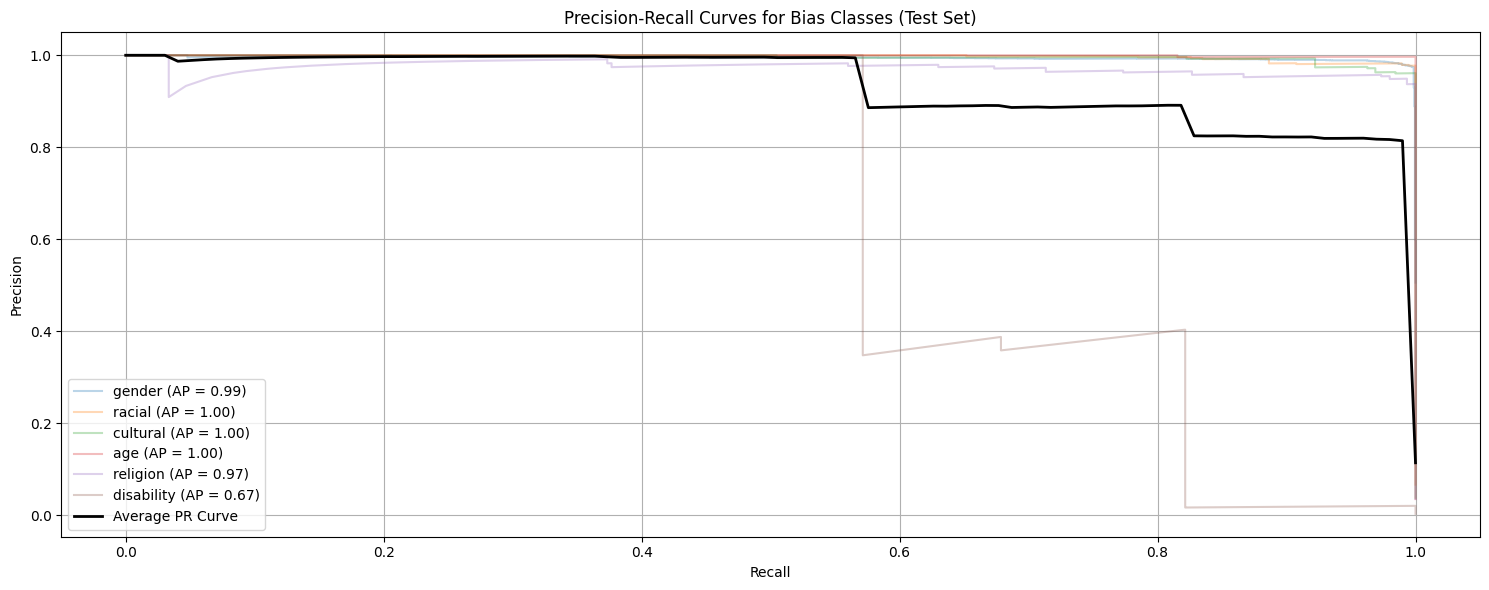

In [52]:
plt.figure(figsize=(15, 6))
mean_precision = 0.0
mean_recall = np.linspace(0, 1, 100)
precisions = []
for i, label in enumerate(label_names):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])
    ap_score = average_precision_score(y_true[:, i], y_probs[:, i])
    mean_precision += np.interp(mean_recall, recall[::-1], precision[::-1])  # Interpolate and reverse recall
    plt.plot(recall, precision, alpha=0.3, label=f"{label.replace('is_', '').replace('_biased', '')} (AP = {ap_score:.2f})")

mean_precision /= len(label_names)  # Average precision across labels
plt.plot(mean_recall, mean_precision, color="black", linewidth=2, label="Average PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves for Bias Classes (Test Set)")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [57]:
import torch
from transformers import ElectraForSequenceClassification, AutoTokenizer
import numpy as np
import pandas as pd

# Load model and tokenizer
model = ElectraForSequenceClassification.from_pretrained("/kaggle/working/model")
tokenizer = AutoTokenizer.from_pretrained("/kaggle/working/tokenizer")

# Move model to appropriate device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define custom prediction function without warnings or summary
def predict_bias_custom(texts=None, csv_path=None):
    model.eval()
    results = []
    if csv_path:
        try:
            df = pd.read_csv(csv_path)
            texts = df["text"].tolist()
        except Exception as e:
            results.append(f"Error reading CSV: {str(e)}")
            texts = []
    
    if not texts:
        results.append("No texts provided. Please provide a list of texts or a valid CSV path.")
        return results

    for idx, text in enumerate(texts, 1):
        # Tokenize input text
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
        # Move inputs to the same device as the model
        inputs = {key: value.to(device) for key, value in inputs.items()}
        # Get model predictions
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probs = torch.sigmoid(logits).cpu().numpy()[0]  # Move to CPU for numpy conversion
        # Format output: only predictions
        labels = ["Gender", "Racial", "Cultural", "Age", "Religion", "Disability"]
        result = [f"{label} Bias ({probs[i]:.2f})" if probs[i] >= 0.5 else f"No {label} Bias ({probs[i]:.2f})" 
                  for i, label in enumerate(labels)]
        results.append(f"Text {idx}: {', '.join(result)}")
    
    return results

# Example custom texts for prediction
custom_texts = [
    "Women are often stereotyped as being less capable in leadership roles.",
    "The software was developed by a diverse team from various countries.",
    "Older employees are less adaptable to new technology.",
    "The festival celebrates cultural traditions from around the world."
]

# Run predictions (optionally provide csv_path="/kaggle/input/custom_texts.csv")
predictions = predict_bias_custom(custom_texts)
for prediction in predictions:
    print(prediction)

Text 1: Gender Bias (0.99), No Racial Bias (0.00), No Cultural Bias (0.00), No Age Bias (0.00), No Religion Bias (0.00), No Disability Bias (0.00)
Text 2: No Gender Bias (0.00), No Racial Bias (0.00), No Cultural Bias (0.00), No Age Bias (0.00), No Religion Bias (0.00), No Disability Bias (0.00)
Text 3: No Gender Bias (0.00), No Racial Bias (0.00), No Cultural Bias (0.00), No Age Bias (0.00), No Religion Bias (0.00), No Disability Bias (0.00)
Text 4: No Gender Bias (0.00), No Racial Bias (0.00), No Cultural Bias (0.00), No Age Bias (0.00), No Religion Bias (0.00), No Disability Bias (0.00)


In [55]:
! pip freeze

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


absl-py==1.4.0
accelerate==1.8.1
aiofiles==22.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.12.13
aiosignal==1.3.2
aiosqlite==0.21.0
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.1
alembic==1.16.2
altair==5.5.0
annotated-types==0.7.0
annoy==1.17.3
ansicolors==1.1.8
antlr4-python3-runtime==4.9.3
anyio==4.9.0
argon2-cffi==25.1.0
argon2-cffi-bindings==21.2.0
args==0.1.0
array_record==0.7.2
arrow==1.3.0
arviz==0.21.0
astropy==7.1.0
astropy-iers-data==0.2025.6.23.0.39.50
asttokens==3.0.0
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
bayesian-optimization==3.0.0
beartype==0.21.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==2.8.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blobfile==3.0.0
blosc2==3.5.0
bokeh==3.7.3
Boruta==0.4.3
boto3==1.39.1
botocore==1.39.1
Bottleneck==1.4.2
-e git+https://github.com/SohierDane/BigQuery_Helper@8615a7f6c1663e7f2d48aa2b32c2dbcb